In [1]:
%matplotlib inline

morange = u'#ff7f0e'
mblue = u'#1f77b4'
mgreen = u'#2ca02c'
mred = u'#d62728'
mpurple = u'#9467bd'

from cosmodc2.sdss_colors import load_umachine_processed_sdss_catalog
sdss = load_umachine_processed_sdss_catalog()
sdss = sdss[sdss['z'] < 0.07]

from astropy.table import Table
mock = Table()

dirname = "/Volumes/simulation_data_2018/protoDC2_v4p6_lf_calibration_data/individual_columns_v4p5"
import os
basename = "{0}_v4.5.npy"
mock['redshift'] = np.load(os.path.join(dirname, basename.format('redshift')))
mock['mstar'] = np.load(os.path.join(dirname, basename.format('mstar')))
mock['mpeak'] = np.load(os.path.join(dirname, basename.format('mpeak')))
mock['hostHaloMass'] = np.load(os.path.join(dirname, basename.format('hostHaloMass')))
mock['mag_r'] = np.load(os.path.join(dirname, basename.format('mag_r')))
mock['mag_g_obs'] = np.load(os.path.join(dirname, basename.format('mag_g_obs')))
mock['mag_r_obs'] = np.load(os.path.join(dirname, basename.format('mag_r_obs')))
mock['mag_i_obs'] = np.load(os.path.join(dirname, basename.format('mag_i_obs')))
mock['upid'] = np.load(os.path.join(dirname, basename.format('upid')))
mock['mag_r_kcorrect'] = mock['mag_r_obs'] - mock['mag_r']



/Users/aphearin/anaconda/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Try lifting $M_\ast$

For some unsettling reason, calling this function with the default arguments changes the mock. This is important to resolve. 

It's worth recalibrating this function anyway, and maybe writing another one to boost stellar mass in other regimes. 


In [20]:
from cosmodc2.stellar_mass_remapping import lift_high_mass_mstar

# mock['new_mstar'] = lift_high_mass_mstar(
#         mock['mpeak'], mock['mstar'], mock['upid'], mock['redshift'],
#         z_table=[0.25, 0.5, 1], slope_table=[0.5, 0.65, 0.8], 
#         pivot_table=[13.25, 13, 12.75])
mock['new_mstar'] = lift_high_mass_mstar(
        mock['mpeak'], mock['mstar'], mock['upid'], mock['redshift'])

print(mock.keys())

['redshift', 'mstar', 'mpeak', 'hostHaloMass', 'mag_r', 'mag_g_obs', 'mag_r_obs', 'mag_i_obs', 'upid', 'mag_r_kcorrect', 'new_mstar']


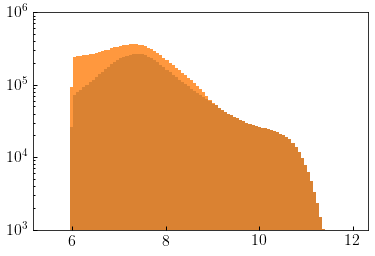

In [42]:
from scipy.stats import powerlaw
num_new_gals = int(4e6)
# num_new_gals = int(4)
fake_mstar = 10**((1 - powerlaw.rvs(2, size=num_new_gals))*3 + 6.)

mock_mask = mock['mstar'] < 10**9
mock_mask *= mock['redshift'] > 0.5
num_cutmock = np.count_nonzero(mock_mask)

fake_galaxies = Table()
for key in mock.keys():
    fake_galaxies[key] = np.zeros(num_new_gals)
fake_galaxies['mstar'] = fake_mstar
fake_galaxies['upid'] = -1

_a = np.arange(num_cutmock)
idx = np.random.choice(_a, replace=True, size=num_new_gals)

fake_galaxies['redshift'] = mock['redshift'][mock_mask][idx]
fake_galaxies['mag_r_kcorrect'] = mock['mag_r_kcorrect'][mock_mask][idx]
fake_galaxies['mpeak'] = mock['mpeak'][mock_mask][idx]

from astropy.table import vstack
newmock = vstack((mock, fake_galaxies))

fig, ax = plt.subplots(1, 1)
__=ax.set_yscale('log')
ylim = ax.set_ylim(1e3, 1e6)
logsm_bins = np.linspace(5.5, 12, 100)

__=ax.hist(np.log10(mock['mstar']), bins=logsm_bins, alpha=0.8)
__=ax.hist(np.log10(newmock['mstar']), bins=logsm_bins, alpha=0.8)

In [55]:
from cosmodc2.sdss_colors.sigmoid_magr_model import magr_monte_carlo

kwargs1 = dict(delta_magr_highz_table=[-6, -5, -4, -1, -0.5, -0.5, -0.5])

from copy import deepcopy
# kwargs2 = deepcopy(kwargs1)
kwargs2 = dict(delta_magr_highz_table=[-6, -5, -4, -1, -0.5, -0.5, -0.5])
# kwargs2 = dict(delta_magr_highz_table=[-7, -5, -3, -1.25, -1, -1, -1],
#                       z_crit_table=[0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.5])

# high_mass_slope = np.interp(newmock['redshift'], [0., 0.7, 0.9], [1.6, 1.6, 2.5])
# kwargs2['high_mass_slope'] = high_mass_slope
# kwargs2['delta_magr_highz_table'] = [-6, -5, -4, -1.25, -1.25, -1., -1.]
# kwargs2['z_crit_table'] = [0.7, 0.7, 0.7, 0.7, 0.9, 0.6, 0.6]

newmock['mag_r'] = magr_monte_carlo(
    newmock['mstar'], newmock['upid'], newmock['redshift'], **kwargs1)
newmock['new_mag_r'] = magr_monte_carlo(
    newmock['new_mstar'], newmock['upid'], newmock['redshift'], **kwargs2)

newmock['mag_r_obs'] = newmock['mag_r_kcorrect'] + newmock['mag_r']
newmock['new_mag_r_obs'] = newmock['mag_r_kcorrect'] + newmock['new_mag_r']


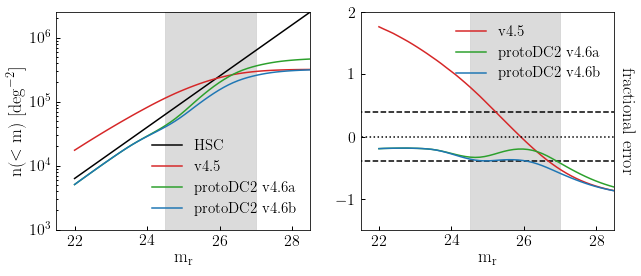

In [56]:
default_flux_bins = np.linspace(22, 28.5, 50)

def dndmag(observed_flux, flux_bins=default_flux_bins, sky_area=25.):
    counts = np.array([np.count_nonzero(observed_flux < x) for x in flux_bins])
    return counts/float(sky_area), flux_bins

dndmag_v4p5, magr_obs_bins = dndmag(mock['mag_r_obs'])
dndmag_v4p6a, magr_obs_bins = dndmag(newmock['mag_r_obs'])
dndmag_v4p6b, magr_obs_bins = dndmag(newmock['new_mag_r_obs'])

c0_hsc_r, c1_hsc_r = -5, 0.4
hsc_dndmagr_abscissa = default_flux_bins
hsc_dndmagr_ordinates = 10**(c0_hsc_r + c1_hsc_r*hsc_dndmagr_abscissa)

fracdiff_dndmag_v4p5 = (dndmag_v4p5 - hsc_dndmagr_ordinates)/hsc_dndmagr_ordinates
fracdiff_dndmag_v4p6a = (dndmag_v4p6a - hsc_dndmagr_ordinates)/hsc_dndmagr_ordinates
fracdiff_dndmag_v4p6b = (dndmag_v4p6b - hsc_dndmagr_ordinates)/hsc_dndmagr_ordinates



fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), sharex=True)
yscale1 = ax1.set_yscale('log')

x1 = np.zeros(100) + 24.5
x2 = np.zeros(100) + 27
__=ax1.fill_betweenx(np.logspace(1, 10, 100), x1, x2, alpha=0.8, color='lightgray')
__=ax2.fill_betweenx(np.linspace(-2, 2, 100), x1, x2, alpha=0.8, color='lightgray')
ylo = np.zeros(100) - 0.4
yhi = np.zeros(100) + 0.4
# __=ax2.fill_between(np.linspace(0, 100, 100), ylo, yhi, alpha=0.8, color='lightgray')
__=ax2.plot(np.linspace(0, 100, 100), ylo, '--', color='k')
__=ax2.plot(np.linspace(0, 100, 100), yhi, '--', color='k')


__=ax1.plot(hsc_dndmagr_abscissa, hsc_dndmagr_ordinates, label=r'${\rm HSC}$', color='k')

__=ax1.plot(magr_obs_bins, dndmag_v4p5, label=r'${\rm v4.5}$', color=mred)
__=ax1.plot(magr_obs_bins, dndmag_v4p6a, label=r'${\rm protoDC2\ v4.6a}$', color=mgreen)
__=ax1.plot(magr_obs_bins, dndmag_v4p6b, label=r'${\rm protoDC2\ v4.6b}$', color=mblue)

xlabel1 = ax1.set_xlabel(r'${\rm m_{r}}$')
ylabel1 = ax1.set_ylabel(r'${\rm n(<m)\ [deg^{-2}]}$')
legend1 = ax1.legend()
ylim1 = ax1.set_ylim(1e3, 2.5e6)
xlim1 = ax1.set_xlim(22, 28)

__=ax2.plot(hsc_dndmagr_abscissa, fracdiff_dndmag_v4p5, 
            label=r'${\rm v4.5}$', color=mred)
__=ax2.plot(hsc_dndmagr_abscissa, fracdiff_dndmag_v4p6a, 
           label=r'${\rm protoDC2\ v4.6a}$', color=mgreen)
__=ax2.plot(hsc_dndmagr_abscissa, fracdiff_dndmag_v4p6b, 
           label=r'${\rm protoDC2\ v4.6b}$', color=mblue)

__=ax2.plot(np.linspace(20, 30, 100), np.zeros(100), ':', color='k')

ax2.yaxis.set_label_position("right")  #  y-labels on the right
xlabel2 = ax2.set_xlabel(r'${\rm m_{r}}$')
ylabel2 = ax2.set_ylabel(r'${\rm fractional\ error}$', rotation=-90, labelpad=20)

xlim2 = ax2.set_xlim(21.5, 28.5)
ylim2 = ax2.set_ylim(-1.5, 2)
leg2 = ax2.legend()
# figname = 'hsc_dndmag_v4p5_vs_v4p6.png'
# fig.savefig(figname, bbox_extra_artists=[xlabel1, ylabel1], bbox_inches='tight')

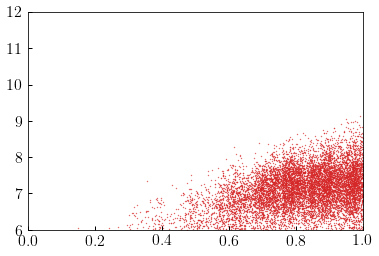

In [57]:
rmask = mock['mag_r_obs'] > 27
rmask2 = (mock['mag_r_obs'] > 25.5) & (mock['mag_r_obs'] < 27)

fig, ax = plt.subplots(1, 1)
nskip=250
__=ax.scatter(mock['redshift'][rmask2][::nskip], 
              np.log10(mock['mstar'][rmask2][::nskip]), s=0.1, color=mred)
# __=ax.scatter(mock['redshift'][rmask][::nskip], 
#               np.log10(mock['mstar'][rmask][::nskip]), s=0.1, color=mblue)
# __=ax.scatter(mock['redshift'][rmask2][::2*nskip], 
#               np.log10(mock['mstar'][rmask2][::2*nskip]), s=0.1, color=mred)
xlim = ax.set_xlim(0, 1)
ylim = ax.set_ylim(6, 12)

In [58]:
# _a = np.arange(len(newmock)).astype(int)

# nselect = int(1e4)

# mask1 = newmock['new_mag_r_obs'] < 24
# mask1 *= newmock['new_mag_r_obs'] > 22

# mask2 = newmock['new_mag_r_obs'] < 27
# mask2 *= newmock['new_mag_r_obs'] > 25.5

# idx1 = np.random.choice(_a[mask1], size=nselect, replace=False)
# idx2 = np.random.choice(_a[mask2], size=nselect, replace=False)


# fig, ax = plt.subplots(1, 1)

# __=ax.scatter(newmock['redshift'][idx1], np.log10(newmock['mstar'][idx1]), s=0.1)
# __=ax.scatter(newmock['redshift'][idx2], np.log10(newmock['mstar'][idx2]), s=0.1)


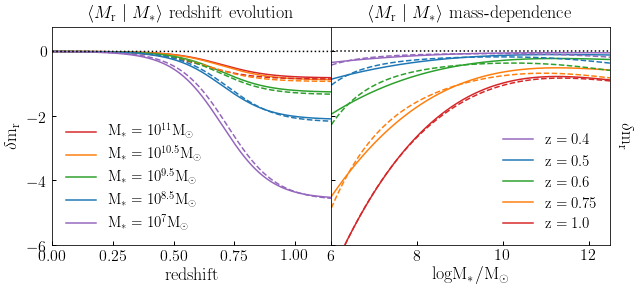

In [59]:
from copy import deepcopy
kwargs2 = deepcopy(kwargs1)

# high_mass_slope = np.interp(newmock['redshift'], [0., 0.7, 0.9], [1.6, 1.6, 2.5])
# kwargs2['high_mass_slope'] = high_mass_slope
# kwargs2['delta_magr_highz_table'] = [-6, -5, -4, -1.25, -1.25, -1., -1.]
# kwargs2['z_crit_table'] = [0.7, 0.7, 0.7, 0.7, 0.9, 0.6, 0.6]




from cosmodc2.sdss_colors.sigmoid_magr_model import delta_magr_vs_mstar_redshift

ngals = int(1e4)
logsm_array = np.linspace(6, 12.5, ngals)
_z = np.zeros(ngals)
zarr = np.linspace(0, 1.5, ngals)
logsm_arr = np.linspace(5.5, 12.75, ngals)

from copy import deepcopy
# kwargs_inspect = dict(delta_magr_highz_table=[-6, -5, -4, -1, -0.5, -0.5, -0.5])
kwargs_inspect = dict(delta_magr_highz_table=[-7, -5, -3, -1, -1, -1, -1])
kwargs_inspect2 = dict(delta_magr_highz_table=[-7, -5, -3, -1.25, -1, -1, -1],
                      z_crit_table=[0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.5])



dmag1a_vsm = delta_magr_vs_mstar_redshift(logsm_arr, _z + 0.4, **kwargs_inspect)
dmag1b_vsm = delta_magr_vs_mstar_redshift(logsm_arr, _z + 0.5, **kwargs_inspect)
dmag1c_vsm = delta_magr_vs_mstar_redshift(logsm_arr, _z + 0.6, **kwargs_inspect)
dmag1d_vsm = delta_magr_vs_mstar_redshift(logsm_arr, _z + 0.75, **kwargs_inspect)
dmag1e_vsm = delta_magr_vs_mstar_redshift(logsm_arr, _z + 1, **kwargs_inspect)

dmag1a_vsz = delta_magr_vs_mstar_redshift(_z + 7, zarr, **kwargs_inspect)
dmag1b_vsz = delta_magr_vs_mstar_redshift(_z + 8.5, zarr, **kwargs_inspect)
dmag1c_vsz = delta_magr_vs_mstar_redshift(_z + 9.5, zarr, **kwargs_inspect)
dmag1d_vsz = delta_magr_vs_mstar_redshift(_z + 10.5, zarr, **kwargs_inspect)
dmag1e_vsz = delta_magr_vs_mstar_redshift(_z + 11.0, zarr, **kwargs_inspect)


dmag2a_vsm = delta_magr_vs_mstar_redshift(logsm_arr, _z + 0.4, **kwargs_inspect2)
dmag2b_vsm = delta_magr_vs_mstar_redshift(logsm_arr, _z + 0.5, **kwargs_inspect2)
dmag2c_vsm = delta_magr_vs_mstar_redshift(logsm_arr, _z + 0.6, **kwargs_inspect2)
dmag2d_vsm = delta_magr_vs_mstar_redshift(logsm_arr, _z + 0.75, **kwargs_inspect2)
dmag2e_vsm = delta_magr_vs_mstar_redshift(logsm_arr, _z + 1, **kwargs_inspect2)

dmag2a_vsz = delta_magr_vs_mstar_redshift(_z + 7, zarr, **kwargs_inspect2)
dmag2b_vsz = delta_magr_vs_mstar_redshift(_z + 8.5, zarr, **kwargs_inspect2)
dmag2c_vsz = delta_magr_vs_mstar_redshift(_z + 9.5, zarr, **kwargs_inspect2)
dmag2d_vsz = delta_magr_vs_mstar_redshift(_z + 10.5, zarr, **kwargs_inspect2)
dmag2e_vsz = delta_magr_vs_mstar_redshift(_z + 11.0, zarr, **kwargs_inspect2)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
fig.subplots_adjust(wspace=0) 

__=ax1.plot(zarr, dmag1e_vsz, label=r'${\rm M_{\ast} = 10^{11}M_{\odot}}$', color=mred)
__=ax1.plot(zarr, dmag1d_vsz, label=r'${\rm M_{\ast} = 10^{10.5}M_{\odot}}$', color=morange)
__=ax1.plot(zarr, dmag1c_vsz, label=r'${\rm M_{\ast} = 10^{9.5}M_{\odot}}$', color=mgreen)
__=ax1.plot(zarr, dmag1b_vsz, label=r'${\rm M_{\ast} = 10^{8.5}M_{\odot}}$', color=mblue)
__=ax1.plot(zarr, dmag1a_vsz, label=r'${\rm M_{\ast} = 10^{7}M_{\odot}}$', color=mpurple)

__=ax1.plot(zarr, dmag2e_vsz, '--', color=mred)
__=ax1.plot(zarr, dmag2d_vsz, '--', color=morange)
__=ax1.plot(zarr, dmag2c_vsz, '--', color=mgreen)
__=ax1.plot(zarr, dmag2b_vsz, '--', color=mblue)
__=ax1.plot(zarr, dmag2a_vsz, '--', color=mpurple)

__=ax1.plot(zarr, np.zeros_like(zarr), ':', color='k')

__=ax2.plot(np.linspace(0, 100, 100), np.zeros(100), ':', color='k')
__=ax2.plot(logsm_arr, dmag1a_vsm, label=r'${\rm z=0.4}$', color=mpurple)
__=ax2.plot(logsm_arr, dmag1b_vsm, label=r'${\rm z=0.5}$', color=mblue)
__=ax2.plot(logsm_arr, dmag1c_vsm, label=r'${\rm z=0.6}$', color=mgreen)
__=ax2.plot(logsm_arr, dmag1d_vsm, label=r'${\rm z=0.75}$', color=morange)
__=ax2.plot(logsm_arr, dmag1e_vsm, label=r'${\rm z=1.0}$', color=mred)

__=ax2.plot(logsm_arr, dmag2a_vsm, '--', color=mpurple)
__=ax2.plot(logsm_arr, dmag2b_vsm, '--', color=mblue)
__=ax2.plot(logsm_arr, dmag2c_vsm, '--', color=mgreen)
__=ax2.plot(logsm_arr, dmag2d_vsm, '--', color=morange)
__=ax2.plot(logsm_arr, dmag2e_vsm, '--', color=mred)

__=ax2.plot(zarr, np.zeros_like(zarr), ':', color='k')

title2 = ax2.set_title(
    r'$\langle M_{\rm r}\ \vert\ M_{\ast}\rangle\ {\rm mass}$-${\rm dependence}$')
xlabel2 = ax2.set_xlabel(r'${\rm logM_{\ast}/M_{\odot}}$')
ylabel2 = ax2.set_ylabel(r'${\rm \delta m_r}$', rotation=-90, labelpad=20)
__=ax2.yaxis.set_label_position("right")  #  y-labels on the right
                            


title = ax1.set_title(r'$\langle M_{\rm r}\ \vert\ M_{\ast}\rangle\ {\rm redshift\ evolution}$')
xlabel1 = ax1.set_xlabel(r'${\rm redshift}$')
ylabel1 = ax1.set_ylabel(r'${\rm \delta m_r}$')

legend1 = ax1.legend()
legend2 = ax2.legend()

xlim1 = ax1.set_xlim(0, 1.15)
xlim2 = ax2.set_xlim(6, 12.5)
ylim2 = ax2.set_ylim(-6, 0.75)

# figname = 'sigmoid_redshift_evolution_model_v4p6.png'
# fig.savefig(figname, bbox_extra_artists=[xlabel1, ylabel1], bbox_inches='tight')

In [60]:
import os
deep2_dirname = "/Users/aphearin/work/repositories/python/cosmodc2/cosmodc2/data"

X = np.loadtxt(os.path.join(deep2_dirname, "deep2_dndz_rband_lt_22.txt"))
deep2_dndz_r22_redshift, deep2_dndz_r22_fit = X[:, 0], X[:, 1]
X = np.loadtxt(os.path.join(deep2_dirname, "deep2_dndz_rband_lt_23.txt"))
deep2_dndz_r23_redshift, deep2_dndz_r23_fit = X[:, 0], X[:, 1]
X = np.loadtxt(os.path.join(deep2_dirname, "deep2_dndz_rband_lt_24.txt"))
deep2_dndz_r24_redshift, deep2_dndz_r24_fit = X[:, 0], X[:, 1]

In [61]:
redshift_bins = np.linspace(0, 1, 15)
redshift_mids = 0.5*(redshift_bins[:-1] + redshift_bins[1:])

mask22 = mock['mag_r_obs'] < 22
mask23 = mock['mag_r_obs'] < 23
mask24 = mock['mag_r_obs'] < 24

pdc2_v4p5_dndz_r22, __ = np.histogram(
    mock['redshift'][mask22], density=True, bins=redshift_bins)
pdc2_v4p5_dndz_r23, __ = np.histogram(
    mock['redshift'][mask23], density=True, bins=redshift_bins)
pdc2_v4p5_dndz_r24, __ = np.histogram(
    mock['redshift'][mask24], density=True, bins=redshift_bins)


mask22 = newmock['mag_r_obs'] < 22
mask23 = newmock['mag_r_obs'] < 23
mask24 = newmock['mag_r_obs'] < 24

pdc2_v4p6a_dndz_r22, __ = np.histogram(
    newmock['redshift'][mask22], density=True, bins=redshift_bins)
pdc2_v4p6a_dndz_r23, __ = np.histogram(
    newmock['redshift'][mask23], density=True, bins=redshift_bins)
pdc2_v4p6a_dndz_r24, __ = np.histogram(
    newmock['redshift'][mask24], density=True, bins=redshift_bins)

mask22 = newmock['new_mag_r_obs'] < 22
mask23 = newmock['new_mag_r_obs'] < 23
mask24 = newmock['new_mag_r_obs'] < 24

pdc2_v4p6b_dndz_r22, __ = np.histogram(
    newmock['redshift'][mask22], density=True, bins=redshift_bins)
pdc2_v4p6b_dndz_r23, __ = np.histogram(
    newmock['redshift'][mask23], density=True, bins=redshift_bins)
pdc2_v4p6b_dndz_r24, __ = np.histogram(
    newmock['redshift'][mask24], density=True, bins=redshift_bins)


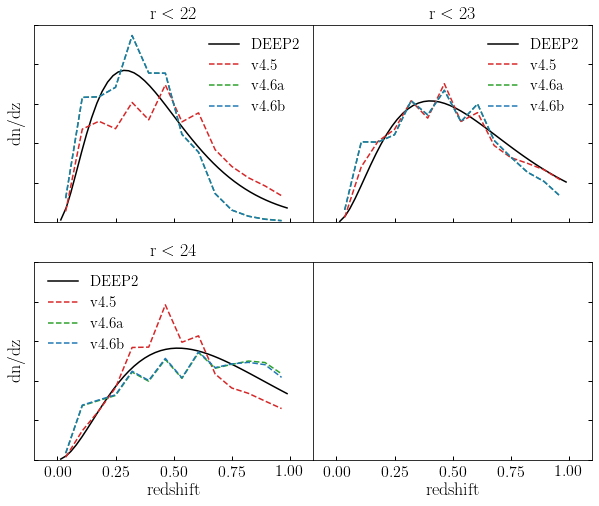

In [62]:
fig, _axes = plt.subplots(2, 2, figsize=(10, 8), sharex=True, sharey=True)
((ax1, ax2), (ax3, ax4)) = _axes
axes = ax1, ax2, ax3, ax4
# fig.subplots_adjust(hspace=0)  #  smash top and bottom plots
fig.subplots_adjust(wspace=0)  #  smash left and right plots
__=ax2.yaxis.set_label_position("right")  #  y-labels on the right
__=ax4.yaxis.set_label_position("right")  #  y-labels on the right
__=ax2.yaxis.tick_right()  #  y-ticks on the right
__=ax4.yaxis.tick_right()  #  y-ticks on the right
__=ax2.set_yticklabels([''])
__=ax4.set_yticklabels([''])
         
    
__=ax1.plot(deep2_dndz_r22_redshift, deep2_dndz_r22_fit, 
           color='k', label=r'${\rm DEEP2}$')
__=ax1.plot(redshift_mids, pdc2_v4p5_dndz_r22, '--', 
           color=mred, label=r'${\rm v4.5}$')
__=ax1.plot(redshift_mids, pdc2_v4p6a_dndz_r22, '--', 
           color=mgreen, label=r'${\rm v4.6a}$')
__=ax1.plot(redshift_mids, pdc2_v4p6b_dndz_r22, '--', 
           color=mblue, label=r'${\rm v4.6b}$')



__=ax2.plot(deep2_dndz_r23_redshift, deep2_dndz_r23_fit, 
           color='k', label=r'${\rm DEEP2}$')
__=ax2.plot(redshift_mids, pdc2_v4p5_dndz_r23, '--', 
           color=mred, label=r'${\rm v4.5}$')
__=ax2.plot(redshift_mids, pdc2_v4p6a_dndz_r23, '--', 
           color=mgreen, label=r'${\rm v4.6a}$')
__=ax2.plot(redshift_mids, pdc2_v4p6b_dndz_r23, '--', 
           color=mblue, label=r'${\rm v4.6b}$')

__=ax3.plot(deep2_dndz_r24_redshift, deep2_dndz_r24_fit, 
           color='k', label=r'${\rm DEEP2}$')
__=ax3.plot(redshift_mids, pdc2_v4p5_dndz_r24, '--', 
           color=mred, label=r'${\rm v4.5}$')
__=ax3.plot(redshift_mids, pdc2_v4p6a_dndz_r24, '--', 
           color=mgreen, label=r'${\rm v4.6a}$')
__=ax3.plot(redshift_mids, pdc2_v4p6b_dndz_r24, '--', 
           color=mblue, label=r'${\rm v4.6b}$')

xlabel3 = ax3.set_xlabel(r'${\rm redshift}$')
xlabel4 = ax4.set_xlabel(r'${\rm redshift}$')
ylabel1 = ax1.set_ylabel(r'${\rm dn/dz}$')
ylabel3 = ax3.set_ylabel(r'${\rm dn/dz}$')

xlim = ax1.set_xlim(-0.1, 1.1)
ylim = ax1.set_ylim(0, 2.5)

legend1 = ax1.legend()
legend2 = ax2.legend()
legend3 = ax3.legend()


title1 = ax1.set_title(r'${\rm r < 22}$')
title2 = ax2.set_title(r'${\rm r < 23}$')
title3 = ax3.set_title(r'${\rm r < 24}$')

# figname = 'deep2_dndz_v4p5_vs_v4p6.pdf'
# fig.savefig(figname, bbox_extra_artists=[xlabel, ylabel], bbox_inches='tight')

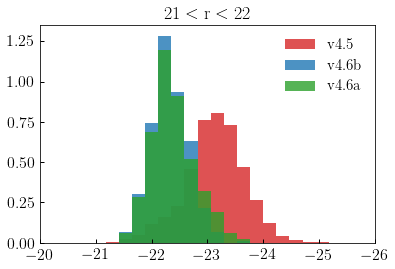

In [63]:
fig, ax = plt.subplots(1, 1)
# __=ax.hist(np.log10(newmock['mstar'][rmask & zmask]), bins=30)

rbins=np.linspace(-28, -20, 35)
normed=True

rlo, rhi = 21, 22
zcut = 0.9
rmask = (mock['mag_r_obs'] >= rlo) & (mock['mag_r_obs'] < rhi)
zmask = (mock['redshift'] > zcut)
__=ax.hist(mock['mag_r'][rmask & zmask], bins=rbins, normed=normed, 
           alpha=0.8, color=mred, label=r'${\rm v4.5}$')

rmask = (newmock['new_mag_r_obs'] >= rlo) & (newmock['new_mag_r_obs'] < rhi)
zmask = (newmock['redshift'] > zcut)
__=ax.hist(newmock['new_mag_r'][rmask & zmask], bins=rbins, normed=normed, 
           alpha=0.8, color=mblue, label=r'${\rm v4.6b}$')

rmask = (newmock['mag_r_obs'] >= rlo) & (newmock['mag_r_obs'] < rhi)
zmask = (newmock['redshift'] > zcut)
__=ax.hist(newmock['mag_r'][rmask & zmask], bins=rbins, normed=normed, 
           alpha=0.8, color=mgreen, label=r'${\rm v4.6a}$')

xlim = ax.set_xlim(-20, -26)
title = ax.set_title(r'${\rm 21 < r < 22}$')
legend = ax.legend()

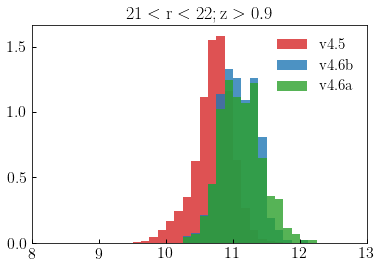

In [64]:
fig, ax = plt.subplots(1, 1)

logsm_bins=np.linspace(8, 12.25, 35)
normed=True

rlo, rhi = 21, 22
zcut = 0.9

rmask = (mock['mag_r_obs'] >= rlo) & (mock['mag_r_obs'] < rhi)
zmask = (mock['redshift'] > zcut)
__=ax.hist(np.log10(mock['mstar'][rmask & zmask]), bins=logsm_bins, normed=normed, 
           alpha=0.8, color=mred, label=r'${\rm v4.5}$')

rmask = (newmock['new_mag_r_obs'] >= rlo) & (newmock['new_mag_r_obs'] < rhi)
zmask = (newmock['redshift'] > zcut)
__=ax.hist(np.log10(newmock['new_mstar'][rmask & zmask]), bins=logsm_bins, normed=normed, 
           alpha=0.8, color=mblue, label=r'${\rm v4.6b}$')

rmask = (newmock['mag_r_obs'] >= rlo) & (newmock['mag_r_obs'] < rhi)
zmask = (newmock['redshift'] > zcut)
__=ax.hist(np.log10(newmock['mstar'][rmask & zmask]), bins=logsm_bins, normed=normed, 
           alpha=0.8, color=mgreen, label=r'${\rm v4.6a}$')

xlim = ax.set_xlim(8, 13)
title = ax.set_title(r'${\rm 21 < r < 22; z>0.9}$')
legend = ax.legend()

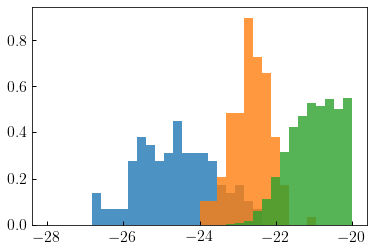

In [71]:
cluster_halo_mask = mock['hostHaloMass'] > 10**14
cenmask = mock['upid'] == -1

cluster_halo_mask2 = newmock['hostHaloMass'] > 10**14
cenmask2 = newmock['upid'] == -1

bcg_mask = cluster_halo_mask & cenmask
bcg_mask2 = cluster_halo_mask2 & cenmask2

cluster_satmask = cluster_halo_mask & ~cenmask
cluster_satmask2 = cluster_halo_mask2 & ~cenmask2

fig, ax = plt.subplots(1, 1)
rbins = np.linspace(-28, -20, 35)

__=ax.hist(mock['mag_r'][bcg_mask], bins=rbins, alpha=0.8, normed=True)
# __=ax.hist(mock['mag_r'][~cenmask], bins=rbins, alpha=0.8, normed=True)

__=ax.hist(newmock['mag_r'][bcg_mask2], bins=rbins, alpha=0.8, normed=True)
__=ax.hist(newmock['mag_r'][cluster_satmask2], bins=rbins, alpha=0.8, normed=True)
